# Asteroid use case notebook

José Peña & Francisco Förster

ALeRCE starter notebook for asteroid science.

In this notebook you will connect to the ALeRCE database, download asteroid candidates, and plot their trajectories. 

You will plot their spatial distribution using datashader aggregation.

Will install first the ALeRCE client.

In [1]:
!pip install git+https://github.com/alercebroker/alerce_client_new.git#egg=alerce

  Cloning https://github.com/alercebroker/alerce_client_new.git to /tmp/pip-install-dwlqulzk/alerce
  Running command git clone -q https://github.com/alercebroker/alerce_client_new.git /tmp/pip-install-dwlqulzk/alerce
     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for alerce: filename=alerce-0.0.1.dev0-cp36-none-any.whl size=8564 sha256=9f1cd3e4cce5609fcbe0636bbfd1c8167cc79aa1a735d3ef4368ab38741a4016
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ul1zb37/wheels/e4/f3/23/8b739fe652c4739e47d6dd0c6090896eaf1b6adecaa7fae2f8
Successfully built alerce


### Load libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from datetime import datetime

In [3]:
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import viridis

Install psycopg2 https://github.com/psycopg/psycopg2

In [4]:
#!pip install psycopg2-binary
import psycopg2

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
from alerce.core import Alerce
client = Alerce()

### Get credentials (in github repository)

In [6]:
import requests
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v3.json"
params = requests.get(url).json()['params']

### Connect to DB

In [7]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

The new DB contains the following tables:
    
* `object`: filter and bandpass aggregated properties per object
* `probability`: classification probabilities
* `magstat`: time aggregated bandpass dependent properties per object
* `ps1_ztf`: closest PanSTARRS object as reported by ZTF
* `ss_ztf`: closest MPC object as reported by ZTF
* `gaia_ztf`: closet GAIA source as reported by ZTF
* `detection`: individual detections, time and bandpass disaggregated
* `feature`: advanced object features, used for machine learning classification
* `non_detection`: limiting magnitudes in previous observations, the largest table of all

### Show all the available tables

In [8]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

,tablename
7,allwise
14,dataquality
13,detection
1,feature
4,gaia_ztf
6,magstat
0,non_detection
2,object
8,pipeline
11,probability


### For each table, show column names and column types

In [9]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,allwise,oid_catalog,character varying
1,allwise,ra,double precision
2,allwise,dec,double precision
3,allwise,w1mpro,double precision
4,allwise,w2mpro,double precision
5,allwise,w3mpro,double precision
6,allwise,w4mpro,double precision
7,allwise,w1sigmpro,double precision
8,allwise,w2sigmpro,double precision
9,allwise,w3sigmpro,double precision


### Query objects which appeared between Jan 1st 2020 and Feb 1st 2020, which have at most one detection, and which are classified as asteroids by the stamp classifier with a probability greater than 0.7

Objects can share the same `oid` (not the `candid`) if they appear at the same position. Asteroids move, so we choose those than appear only once (`ndet=1`).

Probability of being an asteroid is computed in the stamps, so we need to look for those bodies in table `object` that appear as posible asteroids in the table `probability` (in this case, we demand them to have probability higher than 0.7 of being an asteroid).

In [10]:
mjd_first = Time("2020-01-01T00:00:00", scale='utc').mjd
mjd_last = Time("2020-02-01T00:00:00", scale='utc').mjd

query='''
SELECT
object.oid, object.meanra, object.meandec, object.firstmjd,
object.ndet

FROM object
INNER JOIN probability
ON object.oid=probability.oid

WHERE 
object.firstMJD>%s
AND object.firstMJD<%s
AND object.ndet=1
AND probability.classifier_name='stamp_classifier'
AND probability.class_name='Asteroid'
AND probability.probability>0.7
''' % (mjd_first, mjd_last)

ast = pd.read_sql_query(query, conn)
ast.set_index('oid', inplace=True)
print(ast.shape)
ast.head()

(112599, 4)


,meanra,meandec,firstmjd,ndet
oid,,,,
ZTF20aaaeljl,37.554472,41.403419,58849.187072,1
ZTF20aafdqsd,31.634515,41.294746,58862.137338,1
ZTF20aaaclyt,34.036909,42.920540,58849.144005,1
ZTF20aaejdix,20.857953,44.947847,58855.195637,1
ZTF20aaeauow,34.894123,39.536790,58854.160347,1


# Check whether these objects are reported as known asteroids

Once we have all asteroids candidates, we wonder if some of them are known asteroids. So we go to table `ss_ztf` to look for our asteroids candidates using their `oid`.

Table `ss_ztf` gives data from the Minor Planet Center (MPC) of the nearest known body.

In [11]:
query='''
SELECT *
FROM ss_ztf
WHERE 
oid in (%s)
ORDER BY oid
''' % ",".join(["'%s'" % oid for oid in ast.index])

ss = pd.read_sql_query(query, conn)
print(ss.shape)
ss.head()

(112599, 5)


,oid,candid,ssdistnr,ssmagnr,ssnamenr
0,ZTF17aacsnej,1113270013415015015,0.0,17.7,31651
1,ZTF18aabqgan,1123482312215015016,0.0,19.6,209007
2,ZTF18aabtebd,1122337880615015003,0.0,18.7,61128
3,ZTF18abtgcmt,1105089831815015002,1.0,17.0,3629
4,ZTF18abtgodz,1121144804215015000,1.0,18.6,15335


# Plot distribution of separations for those objects with a xmatch in MPC

How many bodies are known asteroids?

How close is a detected bodie to the estimated nearest known body?

Fraction of object with a match in MPC: 0.99


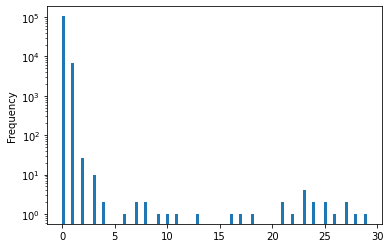

In [12]:
mask = (ss.ssdistnr>=0)
print("Fraction of object with a match in MPC: %.2f" % (mask.sum() / ast.shape[0]))
ss.loc[mask].ssdistnr.plot.hist(bins=100, log=True)

# Move to ecliptic coordinates

Using `astropy.coordinates.SkyCoord` is very easy to move from one coordinate system to another. But be careful: you might be including unnecesary corrections (light-travel time corrections, different origins, etc.)

We tell `astropy` to go from `icrs` to `barycentrictrueecliptic` (both barycentric) since it only applies a simple rotation (althoug we observe from the Earth, not the barycenter).

In [13]:
from astropy.coordinates import SkyCoord
eq = SkyCoord(ast['meanra'].values, ast['meandec'].values, unit='deg', frame='icrs')
ecl = eq.barycentrictrueecliptic

In [14]:
ast["ecl_lat"] = ecl.lat.deg
ast["ecl_long"] = ecl.lon.deg

# Plot histogram of ecliptic latitudes

Text(0, 0.5, 'N')

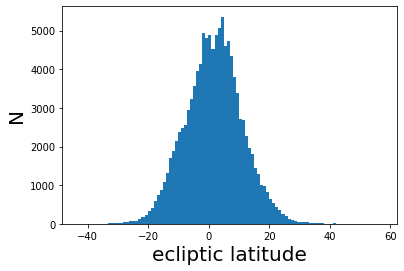

In [15]:
fig, ax = plt.subplots()
ax.hist(ast.ecl_lat, bins=100);
ax.set_xlabel("ecliptic latitude", fontsize=20)
ax.set_ylabel("N", fontsize=20)

Note that most selected objects are around the ecliptic. Also note that you can see individual tracks!

# Plot ecliptic coordinates in the sky using datashader

In [ ]:
!pip install datashader
import datashader as ds

/usr/local/lib/python3.6/dist-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


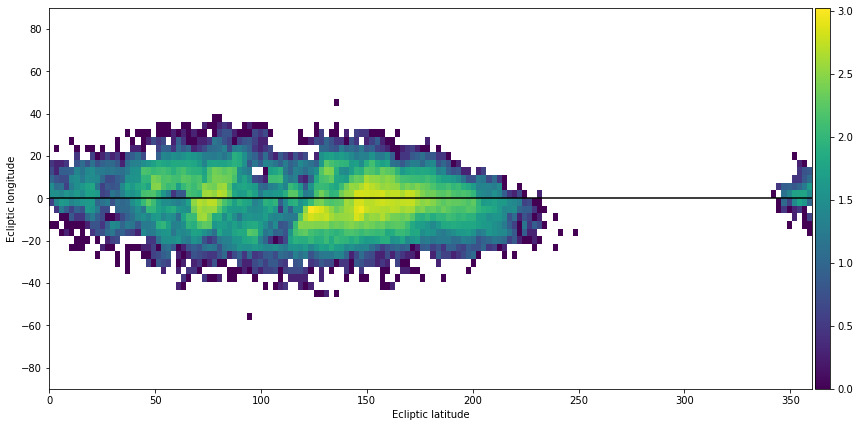

In [18]:
# do datashade aggregation
x_range = [0, 360]
y_range = [-90, 90]
cvs = ds.Canvas(plot_width=150, plot_height=50, x_range=x_range, y_range=y_range)
agg = cvs.points(ast, 'ecl_long', 'ecl_lat')

# show result
fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(np.log10(agg), extent=x_range + y_range)
ax.set_xlabel("Ecliptic latitude")
ax.set_ylabel("Ecliptic longitude")
ax.axhline(0, c='k')

# add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

As expected, almost all asteroids are near the ecliptic plane

# Show the object with the largest number of detections

Lets look for a pretty example. Lets find the (known) asteroid with the most detections and see how it looks like.

In [25]:
ndet = ss.loc[mask].groupby("ssnamenr").apply(lambda df: df.shape[0])

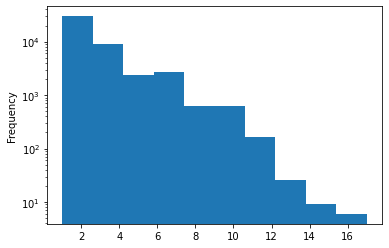

In [26]:
ndet.plot.hist(log=True)

`ndet` is a table with the amount of apparitions of each known asteroid.

In [28]:
ndet.head()

ssnamenr
100012    2
100028    1
100035    2
100041    1
10005     2
dtype: int64

# Plot the trajectories of all asteroids with at least 9 detections in equatorial and ecliptic coordinates

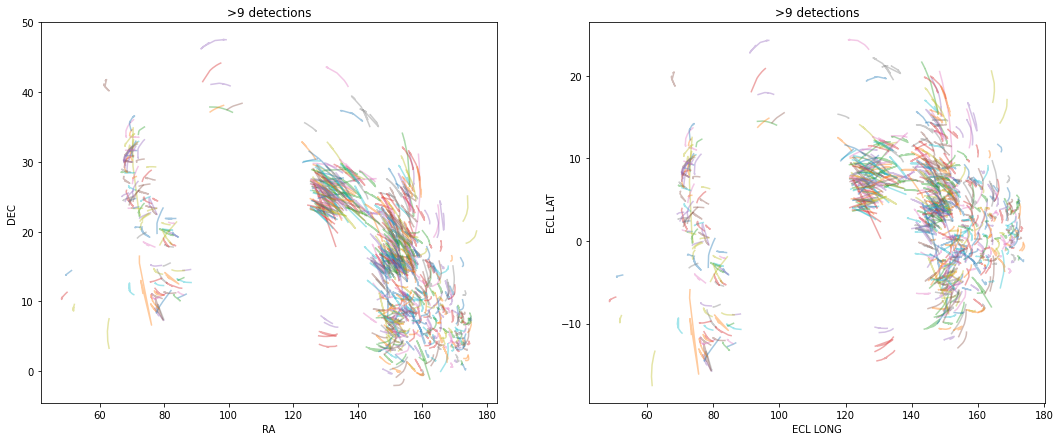

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(18,7))
ndetmin = 9
for ssnamenr in ndet.loc[ndet>=ndetmin].index: # Getting the names of asteroids with at least 9 detections

  oids = ss.loc[ss.ssnamenr==ssnamenr].oid     # Getting the oids of the known asteroid in table 'ss'
  mask = ast.index.isin(oids)                  # Getting if oids in table 'ast' is in oids (from 'ss' of known bodies) 

  ax[0].plot(ast.loc[mask].meanra, ast.loc[mask].meandec, alpha=0.4)
  ax[0].set_title(">%i detections" % ndetmin); ax[0].set_xlabel("RA"); ax[0].set_ylabel("DEC")

  ax[1].plot(ast.loc[mask].ecl_long, ast.loc[mask].ecl_lat, alpha=0.4)
  ax[1].set_title(r">%i detections" % ndetmin); ax[1].set_xlabel("ECL LONG"); ax[1].set_ylabel("ECL LAT")

# Focus on the asteroid with the most detections (*10586*)

In [36]:
bestast = ndet.idxmax()
print(bestast)

10586


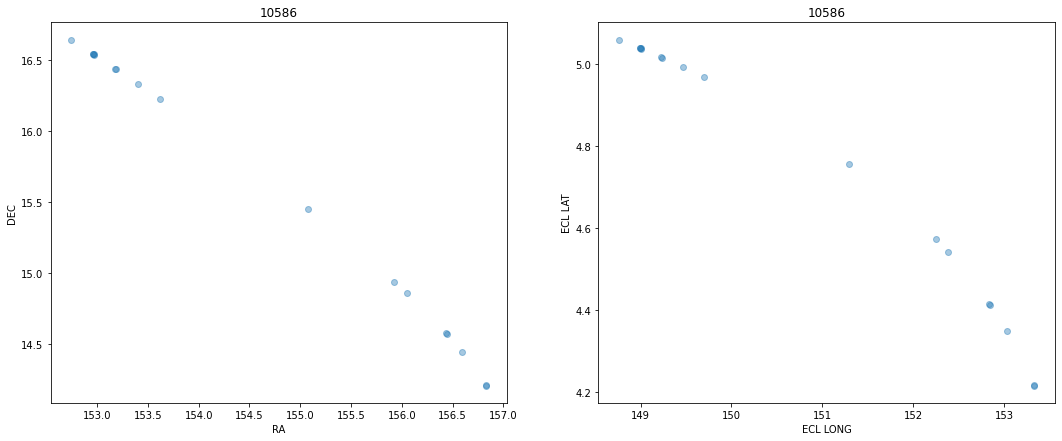

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(18,7))
oids = ss.loc[ss.ssnamenr == bestast].oid
maskbest = ast.index.isin(oids)

ax[0].scatter(ast.loc[maskbest].meanra, ast.loc[maskbest].meandec, alpha=0.4)
ax[0].set_title(bestast); ax[0].set_xlabel("RA"); ax[0].set_ylabel("DEC")

ax[1].scatter(ast.loc[maskbest].ecl_long, ast.loc[maskbest].ecl_lat, alpha=0.4)
ax[1].set_title(bestast); ax[1].set_xlabel("ECL LONG"); ax[1].set_ylabel("ECL LAT")
plt.show()

# Query and plot the light curve of *10586*

Magnitudes, colors and light curves give are important for asteroids' analysis. Having the `oid` of the detections we want (in this case, for the asteroid _10586_) we can get their magnitudes from table `detection` (we could also have used the table `magstat`).

In [41]:
query='''
SELECT oid, mjd, fid, magap, sigmagap, has_stamp
FROM detection
WHERE 
oid in (%s)
ORDER BY oid
''' % ",".join(["'%s'" % oid for oid in oids])

dets = pd.read_sql_query(query, conn)
print(dets.shape)
dets

(17, 6)


,oid,mjd,fid,magap,sigmagap,has_stamp
0,ZTF20aaawzpt,58849.454514,2,18.4212,0.0660,True
1,ZTF20aaaykbk,58849.497639,1,19.1998,0.0968,True
2,ZTF20aadwskl,58853.479525,1,19.3473,0.1080,True
3,ZTF20aaeknkj,58855.363160,2,18.5829,0.1200,True
4,ZTF20aaemirb,58855.482512,1,19.0423,0.1068,True
5,ZTF20aaeuipf,58859.336829,2,18.2371,0.1638,True
6,ZTF20aaeysyb,58860.357234,2,18.3724,0.2010,True
7,ZTF20aagkyax,58866.371285,2,18.4577,0.0758,True
8,ZTF20aaiorzt,58874.305185,2,18.1084,0.0414,True
9,ZTF20aajalvd,58875.299757,2,18.0285,0.0373,True


Plot the predicted light curve (by MPC) and compare it to the observed light curve in g and r bands

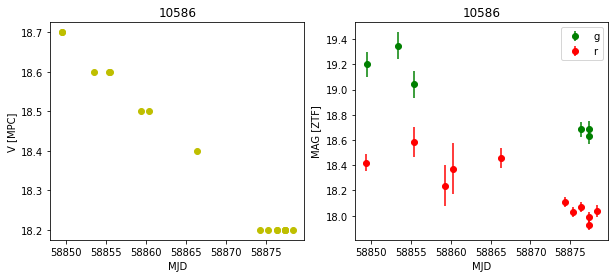

In [49]:
# Just how we got oids, we can get MPC's magnitudes
#Vmpc = ss.loc[ss.oid.isin(oids)].ssmagnr.values
Vmpc = ss.loc[ss.ssnamenr == bestast].ssmagnr.values

# We extract mjds and magnitudes we got from table 'detection'
t = dets.mjd.values; mags = dets.magap.values; mags_err = dets.sigmagap.values
# ZTF observes in two filters: g & r
filters = dets.fid.values; g = filters==1; r = filters==2

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

ax[0].scatter(t, Vmpc, color='y')
ax[0].set_title(bestast); ax[0].set_xlabel("MJD"); ax[0].set_ylabel("V [MPC]")

ax[1].errorbar(t[g], mags[g], yerr=mags_err[g], color='g', label='g', fmt='o')
ax[1].errorbar(t[r], mags[r], yerr=mags_err[r], color='r', label='r', fmt='o')
ax[1].set_title(bestast); ax[1].set_xlabel("MJD"); ax[1].set_ylabel("MAG [ZTF]")
ax[1].legend()

plt.show()

# Show the image stamps of *10586*

If you want to do your own photometry or your own image subtraction or get some morphological characterization (important for comets), do some visual inspection or just a nice gif, you may want to acces the stamps of your candidates.

To get the stamps, you need to use the `client` of `Alerce`.

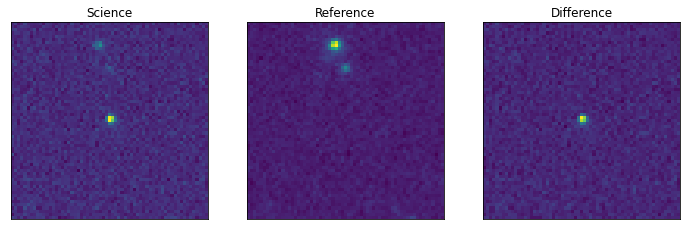

In [51]:
import sys

for oid in oids:
    try:
        stamps = client.get_stamps(oid) # get_stamps(oid) returns three fits-like images
        if stamps is None:
          print("Could not find stamp for object id %s" % oid)
          continue
        
        fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        titles = ['Science', 'Reference', 'Difference']
        for idx, im in enumerate([science, ref, difference]): 
            ax[idx].imshow(im, cmap='viridis') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False); ax[idx].axes.get_yaxis().set_visible(False)
            ax[idx].set_title(titles[idx])
        plt.show()
    except: print("%s ERROR:" %oid, sys.exc_info())
    break

# Getting the ephemerides

ALEPH: Alerce Ephemerides (under construction, but preview available):

    from aleph_test import Query
    from astropy.coordinates import EarthLocation
    from astropy import units as u

    observer = EarthLocation.of_site('Palomar')
    q = Query.Query()

    ras_aleph = []; decs_aleph = []
    ras = []; decs = []
    for idx in np.where(maskbest)[0]:
        epoch = Time(ast.firstmjd[idx], format='mjd', scale='utc')
        center = SkyCoord(ast.meanra[idx], ast.meandec[idx], unit='deg')
        eph = q.query_nb(center, 1*u.deg, epoch=epoch, observer=observer, ast_idxs=(int(bestast)-1,))
        ras_aleph.append(eph['ra'][0]); decs_aleph.append(eph['dec'][0])
        ras.append(ast.meanra[idx]); decs.append(ast.meandec[idx])
    coords_aleph = SkyCoord(ras_aleph, decs_aleph)
    coords_ztf = SkyCoord(ras, decs, unit='deg')

Although ALEPH is not yet publicly available, we have precomputed the ephemerides for the asteroid with the most detections.

In [53]:
from astropy import units as u
import urllib.request
import pickle

coords_aleph = pickle.load(urllib.request.urlopen("https://github.com/alercebroker/usecases/blob/master/notebooks/colab/data/ephs_10586_20200101-20200102.pkl?raw=true"))
coords_ztf = SkyCoord(ast.loc[maskbest].meanra.values, ast.loc[maskbest].meandec.values, unit='deg')

In [54]:
coords_aleph.separation(coords_ztf).arcsec

array([1.59508169e-01, 1.62589492e-01, 1.17570305e-01, 5.95772832e-02,
       4.97824205e-02, 1.61606453e-01, 2.29394464e-01, 7.46484154e-02,
       5.07181932e+02, 5.07456330e+02, 1.53627916e-01, 2.01369680e-01,
       1.51577848e-01, 9.02542159e-02, 7.79946794e-02, 5.98666481e-02,
       1.40302243e-01])

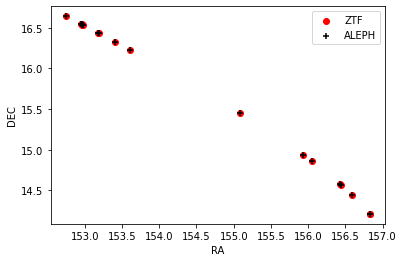

In [55]:
plt.scatter(coords_ztf.ra.deg, coords_ztf.dec.deg, color='r', label="ZTF")
plt.scatter(coords_aleph.ra.deg, coords_aleph.dec.deg, color='k', marker='+', label="ALEPH")
plt.xlabel("RA")
plt.ylabel('DEC')
plt.legend()

# ALEPH vs. Public Services

We now show the distribution of distances between the observed coordinates and those computed by the MPC, the IMCCE, and ALEPH. 

* MPC: https://minorplanetcenter.net/cgi-bin/checkmp.cgi (it only allows time precision of 0.01 days)
* IMCCE: http://vo.imcce.fr/webservices/miriade/?ephemph and Python's `astroquery.imcce.Skybot`

<img src="https://raw.githubusercontent.com/alercebroker/usecases/master/notebooks/colab/figures/dists_contours.png">

IMCCE and ALEPH's ephemerides consider the gravitational pull from the Sun and the planets (plus Pluto). ALEPH's coordinates are more precise and less biased!
(and calculated in similar times).